# Timeseries forecasting for weather prediction

**Authors:** [Prabhanshu Attri](https://prabhanshu.com/github), [Yashika Sharma](https://github.com/yashika51), [Kristi Takach](https://github.com/ktakattack), [Falak Shah](https://github.com/falaktheoptimist)<br>
**Date created:** 2020/06/23<br>
**Last modified:** 2020/07/20<br>
**Description:** This notebook demonstrates how to do timeseries forecasting using a LSTM model.

## Setup
This example requires TensorFlow 2.3 or higher.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [22]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

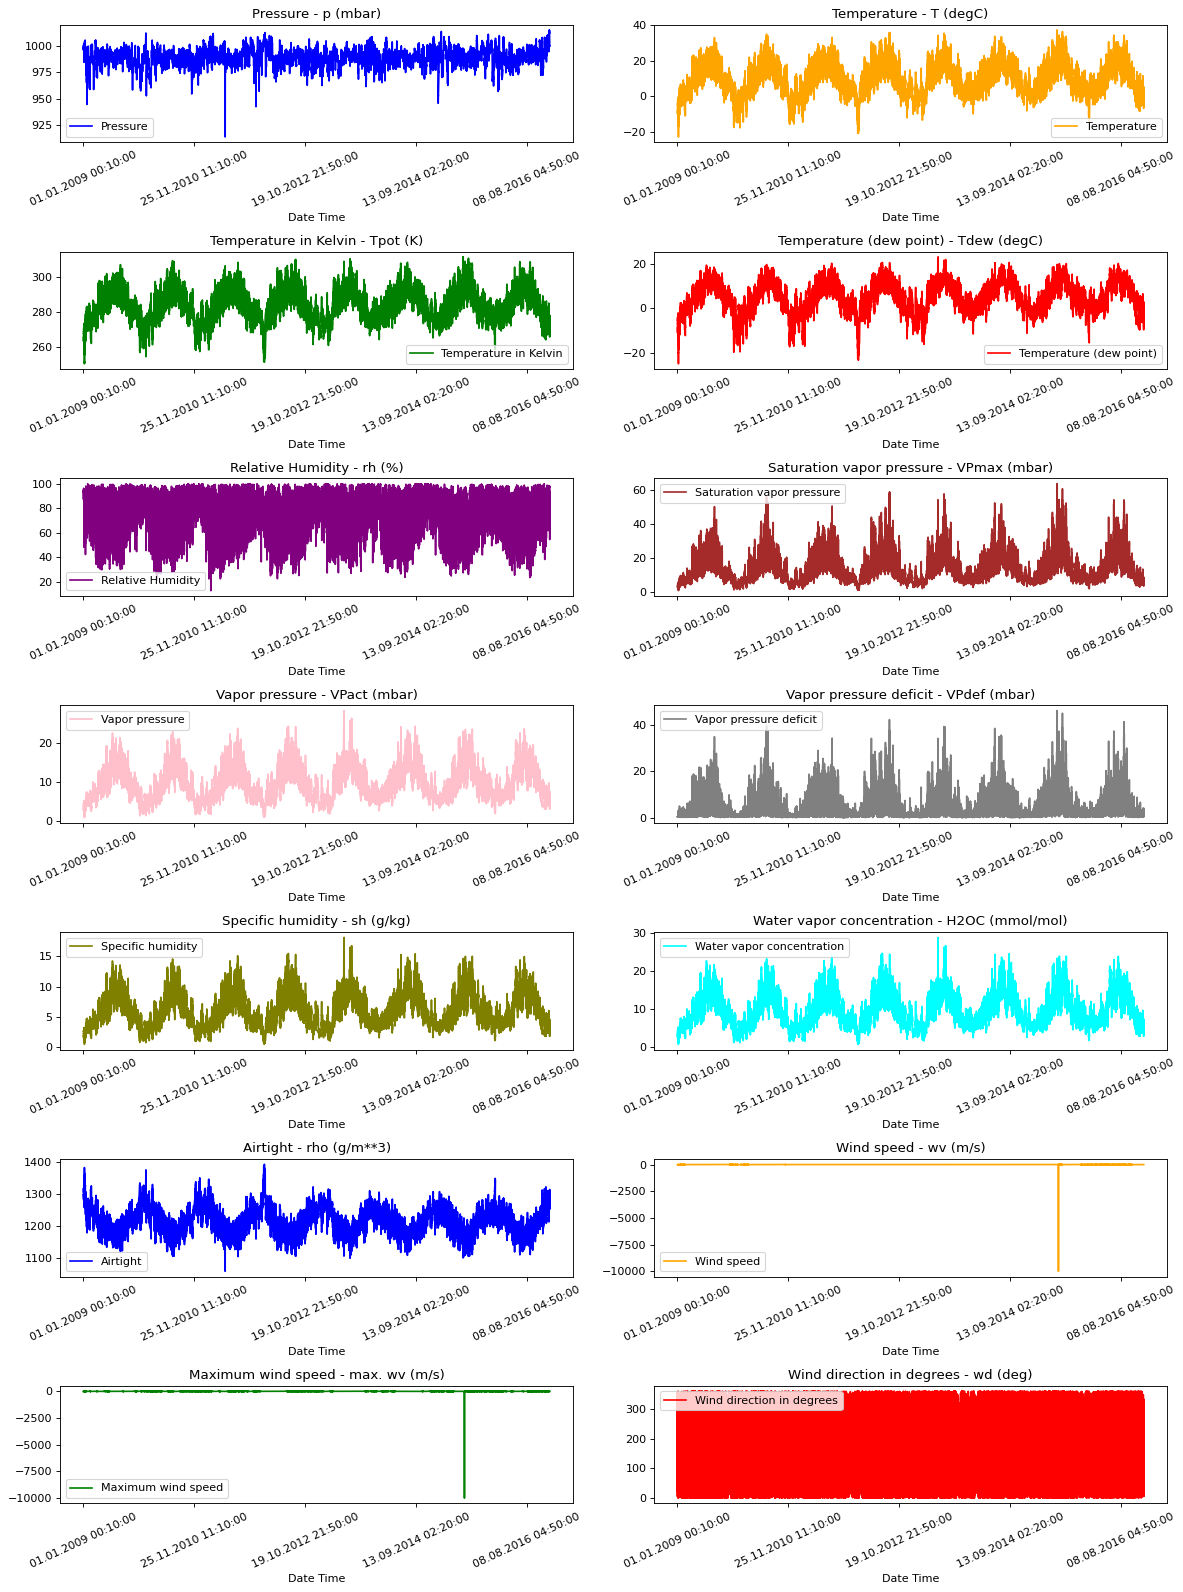

In [23]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

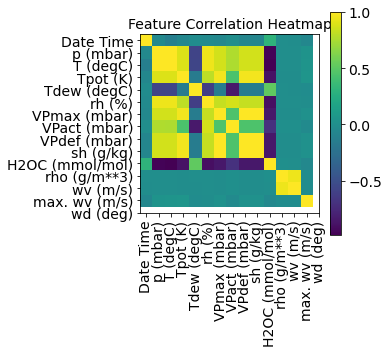

In [24]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


## Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (72/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [25]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

# past = 720
past = 1440
future = 36
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [26]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [27]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [28]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [29]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 240, 7)
Target shape: (256, 1)


## Training

In [36]:
# inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# lstm_out = keras.layers.LSTM(32)(inputs)
# outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Sequential()
model.add(keras.layers.LSTM(32, return_sequences=True,
               input_shape=(inputs.shape[1], inputs.shape[2])))  # returns a sequence of vectors of dimension 32
model.add(keras.layers.LSTM(32))  # return a single vector of dimension 32
model.add(keras.layers.Dense(1, activation=None))

# model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 240, 32)           5120      
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [37]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1169/1169 [==============================] - ETA: 0s - loss: 0.1686
Epoch 00001: val_loss improved from inf to 0.13383, saving model to model_checkpoint.h5
1169/1169 [==============================] - 67s 54ms/step - loss: 0.1686 - val_loss: 0.1338
Epoch 2/10
1169/1169 [==============================] - ETA: 0s - loss: 0.0977
Epoch 00002: val_loss did not improve from 0.13383
1169/1169 [==============================] - 67s 58ms/step - loss: 0.0977 - val_loss: 0.1419
Epoch 3/10
1168/1169 [============================>.] - ETA: 0s - loss: 0.0888
Epoch 00003: val_loss improved from 0.13383 to 0.11901, saving model to model_checkpoint.h5
1169/1169 [==============================] - 66s 57ms/step - loss: 0.0888 - val_loss: 0.1190
Epoch 4/10
1168/1169 [============================>.] - ETA: 0s - loss: 0.0826- ETA: 0s - loss: 
Epoch 00004: val_loss improved from 0.11901 to 0.11542, saving model to model_checkpoint.h5
1169/1169 [==============================] - 66s 56ms/step - los

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

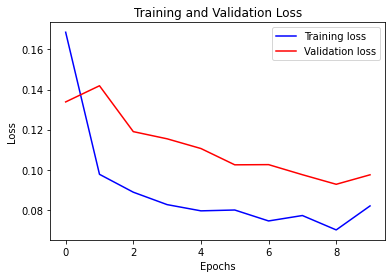

In [38]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

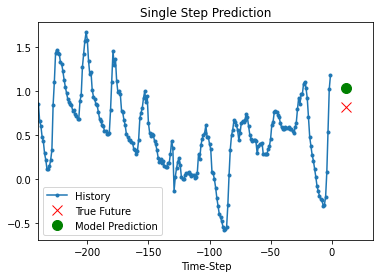

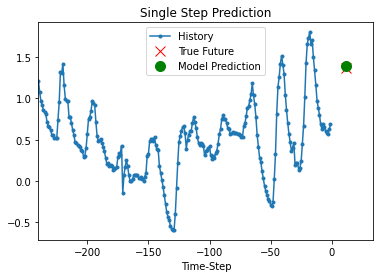

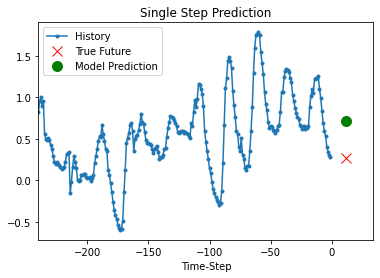

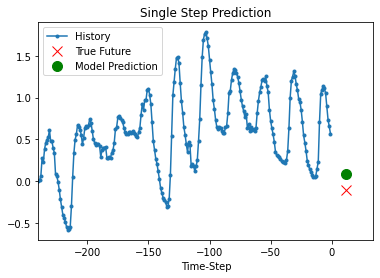

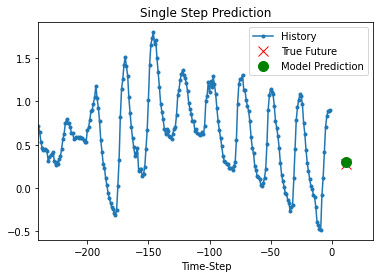

In [39]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )